### Task 1 - Data preparation (2 points)


#### Step 1
(1 point) You are provided three files, i.e., text files containing bus logs of 3 different scenarios

#### Step 2
(1 point) A Python module to read the datasets is available HERE  Download HERE. Download the module and use it to create three separate data frames for the cases: (1) Injection of FF as Speed, (2) Injection of RPM, and (3) No injection. The last field of the data sets marks the CAN message as an injected message or not; it takes value 1 for attack/injection and 0 for the legitimate messages.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from csv import reader


def getData(folder: str, filename: str):
    canData = []  #List to store teh can data
    f = open(Path(folder) / filename)
    read_file = reader(f)
    file = list(read_file)
    speed = []
    rpm = []
    i = 0
    for row in file:
        row = str(row)
        record = {'stamp': row[3:20], 'PID': row[27:30], 'const1': row[31:35], 'change': row[35:43],
                  'value': int(row[43:47], 16), 'attack': 0}
        record["attack"] = 0  # Default is no attack

        #The PID of the speed is 254
        if record["PID"] == '254':  #Processing of speed
            if record["value"] >= 4095:
                record["attack"] = 1

            #The two lines below compute the speed from the last 4 bytes of the data frame
            record['value'] = (record['value'] * 0.62137119) / 100
            speed.append(record['value'])
            #print("i == ",i, "speed= ", record['value'])

        #The PID of RPM readings is 115
        if record["PID"] == '115':  #Processing of RPM
            if record["value"] >= 65535:
                record["attack"] = 1

            #The two lines below compute the RPM from the last 4 bytes of the data frame
            record['value'] = (record['value'] * 2)
            rpm.append(record['value'])
        i = i + 1
        canData.append(record)
        record = {}

    f.close()
    canData = pd.DataFrame(canData)
    canData['speed'] = pd.Series(speed)
    canData['rpm'] = pd.Series(rpm)
    #The speed dataframe gives the sequence of the speed readings
    #The RPM dataset gives the sequence of RPM readings
    return canData

In [2]:
folder = 'D:\BitBucket/5214\Assignment 1\CAN Bus log/'
inj_speed = getData(folder=folder, filename='CAN Bus log - injection of FFF as the speed reading.log')
inj_rpm = getData(folder=folder, filename='CAN Bus log - injection of RPM readings.log')
no_inj = getData(folder=folder, filename='CAN Bus log - no injection of messages.log')
inj_speed.head()

,stamp,PID,const1,change,value,attack,speed,rpm
0,1522028465.309906,264,0003,848C0100,32118.0,0,0.0,626.0
1,1522028465.310141,342,0027,073F0E00,14789.0,0,0.0,624.0
2,1522028465.310396,344,A5A1,B1A8459C,16384.0,0,0.0,624.0
3,1522028465.310662,40A,C102,39393738,12544.0,0,0.0,626.0
4,1522028465.310916,262,0800,08003253,40394.0,0,0.0,626.0


In [3]:
inj_speed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88492 entries, 0 to 88491
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   stamp   88492 non-null  object 
 1   PID     88492 non-null  object 
 2   const1  88492 non-null  object 
 3   change  88492 non-null  object 
 4   value   88492 non-null  float64
 5   attack  88492 non-null  int64  
 6   speed   11306 non-null  float64
 7   rpm     3129 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 5.4+ MB


### Task 2 - Explore and analyze the data (12 points)


In [4]:
class EDA:
    def __init__(self, data: pd.DataFrame):
        self.data = data
        # self.equalized_data = pd.DataFrame(columns=['speed', 'rpm'])

    def equalize(self):
        '''This function takes average values of adjacent speed / rpm to equalize the numbers of speed and rpm in a data'''
        equalized_data = self.data[['speed', 'rpm']].dropna(how='all').reset_index()
        speed_count, rpm_count, = 0, 0
        speed_series, rpm_series = [], []
        for index, row in equalized_data.iterrows():
            if row['speed'] and np.isnan(row['rpm']):
                speed_count += 1
            elif row['rpm'] and np.isnan(row['speed']):
                rpm_count += 1
            else:
                speed_count += 1
                rpm_count += 1
                # Append the avg of both according to count
                speed_avg = np.average(equalized_data.loc[index - speed_count + 1: index + 1, 'speed'])
                rpm_avg = np.average(equalized_data.loc[index - rpm_count + 1: index + 1, 'rpm'])
                speed_series.append(speed_avg)
                rpm_series.append(rpm_avg)
                speed_count, rpm_count = 0, 0
        # Combine them to a DataFrame making sure they have equal length
        self.equalized_data = pd.DataFrame(zip(speed_series, rpm_series), columns=['speed', 'rpm'])
        # Drop last column if it has Nan
        self.equalized_data.dropna(how='any', inplace=True)

    def draw_scatter(self):
        fig, ax = plt.subplots()
        marker_size = 1
        ax.scatter(self.equalized_data.index, self.equalized_data['speed'], color='b', s=marker_size)
        ax2 = ax.twinx()
        ax2.scatter(self.equalized_data.index, self.equalized_data['rpm'], color='r', s=marker_size)
        ax.set_xlabel('Time')
        ax.set_ylabel('Speed', color='b')
        ax.tick_params('y', colors='b')
        ax2.set_ylabel('RPM', color='r')
        ax2.tick_params('y', colors='r')
        plt.title("Plot of speed and rpm")
        plt.show()

    def make_frequency_plot(self):
        sb.countplot(data=self.data[['speed', 'rpm']])

#### Step 1
(4 points)  - Create scatter plots for the three scenarios below<br>(1) Change of speed over time,
(2) Change of RPM over time,
(3) Relationship between speed and RPM.
Reflect on the nine plots (three plots for each scenario) and report your observations in about two paragraphs.

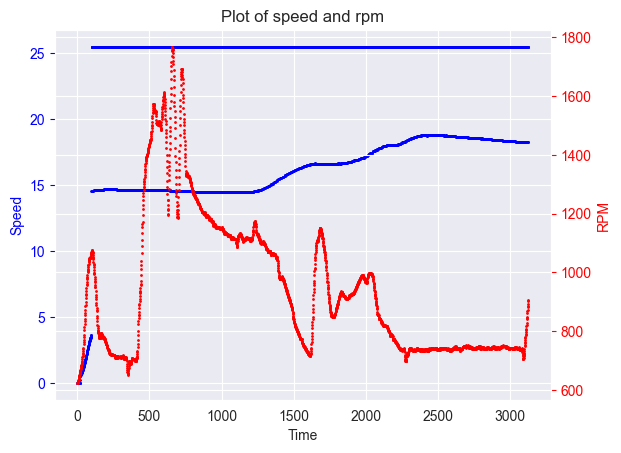

In [5]:
inj_speed_eda = EDA(inj_speed)
inj_speed_eda.equalize()
inj_speed_eda.draw_scatter()

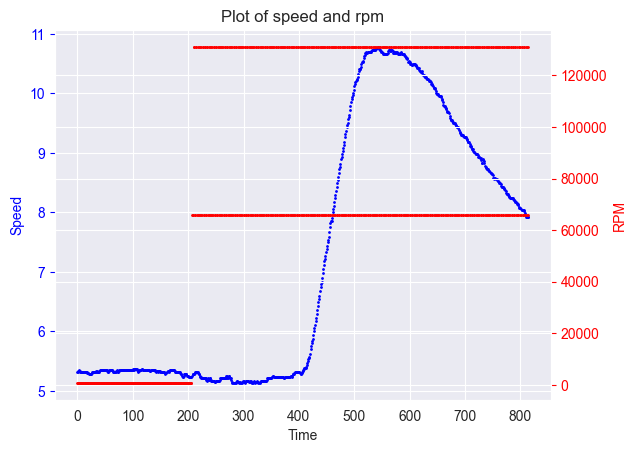

In [6]:
inj_rpm_eda = EDA(inj_rpm)
inj_rpm_eda.equalize()
inj_rpm_eda.draw_scatter()

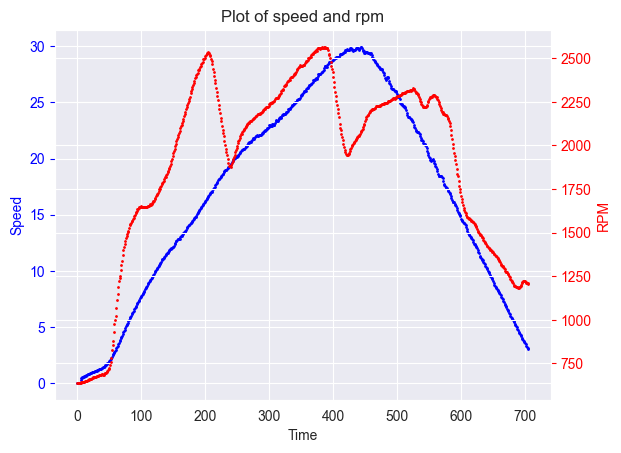

In [7]:
no_inj_eda = EDA(no_inj)
no_inj_eda.equalize()
no_inj_eda.draw_scatter()

#### Analysis
In the case of speed injection, speed looks strange as there are two constant lines with a disconnected slope initially while rpm looks fine, which is understandable. The plot of speed and rpm does not show clear relation ship of them.
In the case of rpm injection, speed looks fine while rpm looks strange with horizontal lines, which is understandable. The plot of speed and rpm does not show any relationship of them.
In the case of rpm injection, speed and rpm look normal. Speed and rpm show some direct propotion.

#### Step 2
(4 points) Create frequency plots of the speed and RPM readings for the three data frames. Then, reflect on the plots and report your observations in three paragraphs, each paragraph discussing one scenario

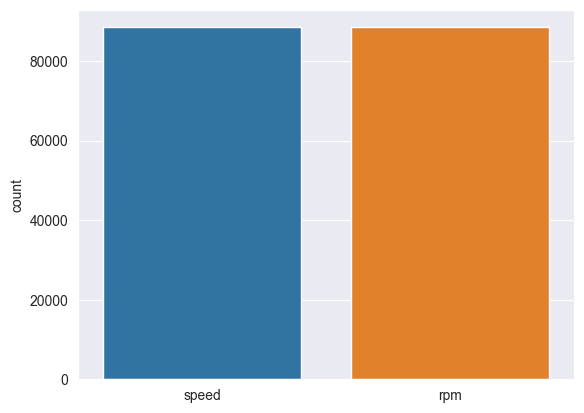

In [8]:
inj_speed_eda.make_frequency_plot()

Speed takes up to four times of rpm, which is understandable in the dataset that speed is injected.

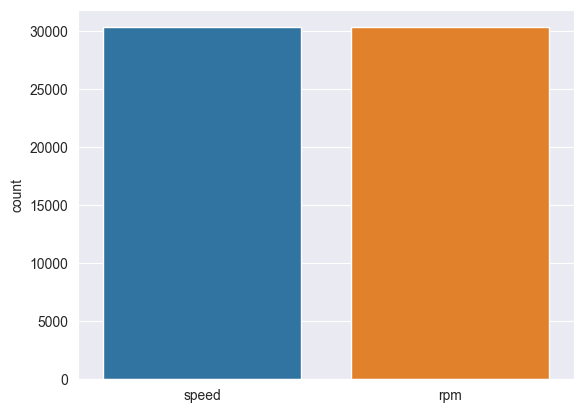

In [9]:
inj_rpm_eda.make_frequency_plot()

RPM takes up to four times of rpm, which is understandable in the dataset that rpm is injected.

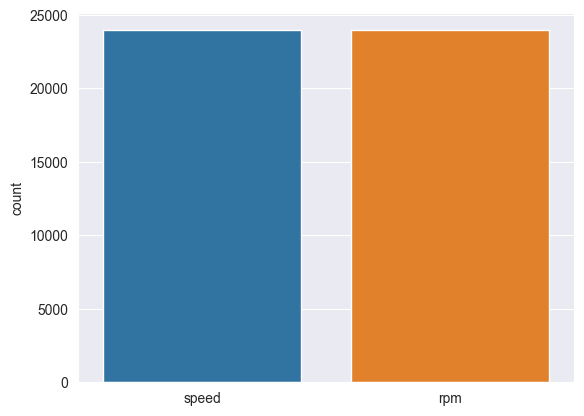

In [10]:
no_inj_eda.make_frequency_plot()

Speed and rpm don't differ very much in terms of frequency, which makes sense when neither of them is injected

#### Step 3
(4 points) Use Pearson-Correlation to analyze the relationships between the Speed and RPM readings plots in all three scenarios. Create a correlation table depicting the correlation coefficients and the associated P-value. Reflect on the values you obtained and write one or two paragraphs to report your observations.

In [11]:
from scipy.stats import pearsonr

corr_table = pd.DataFrame([pearsonr(inj_speed_eda.equalized_data.iloc[:, 0], inj_speed_eda.equalized_data.iloc[:, 1]),
                           pearsonr(inj_rpm_eda.equalized_data.iloc[:, 0], inj_rpm_eda.equalized_data.iloc[:, 1]),
                           pearsonr(no_inj_eda.equalized_data.iloc[:, 0], no_inj_eda.equalized_data.iloc[:, 1])],
                          columns=['correlation', 'p-value'], index=['inj_speed', 'inj_rpm', 'no_inj'])
corr_table

,correlation,p-value
inj_speed,-0.019556,2.742081e-01
inj_rpm,0.423663,7.803394e-37
no_inj,0.855722,1.260754e-203


Because increasing sample size does not increase correlation, I decrease the size of speed / rpm depending on whichever is outnumbered than the other in all three scenarios so that the correlation can be calculated between equal sizes. From my observation, speed and rpm sandwich together repeatedly; then, assuming the adjacent PID status come from the nearly same time is also reasonable.
**Terminology**:
In correlation, a p-value tells us the probability that randomly drawn dots will result in a similarly strong or stronger relationship. Thus, the smaller the p-value the more confidence we have in the predictions we make with the line.
**Observation**:
* In the case that speed suffers injections, we can significantly (p-value is almost zero) conclude that speed and rpm do not have correlation.
* In the case that rpm suffers injections, we can significantly (p-value is almost zero) conclude that speed and rpm have somewhat correlation.
* In the case of no injections, we can significantly (p-value is almost zero) conclude that speed and rpm have strong correlation.

### Task 3 - Supervised Machine Learning Model (20 points)
You are tasked to apply a supervised ML method of your choice (Random Forest, XGBoost, Decision Tree, Support Vector Machine, Logistic Regression, etc.) to detect if there have been attacks in the vehicle or not for each of the three datasets.

1. Combine the three datasets into one large dataset.
2. Split the datasets into two sets: 3/4 as the training dataset and 1/4 as the testing dataset.
3. Train your choice of ML model on the training dataset.
4. Evaluate your model by testing it using the test data set. Create a confusion matrix that summarizes your results.
5. Report the results of your model and your analysis of its performance.

In [12]:
# Combine the three datasets into one large dataset.
df = pd.concat([inj_speed, inj_rpm, no_inj], axis=0)
# Drop meaningless columns
df = df[['value', 'speed', 'rpm', 'attack']]
y = df['attack']
X = df.drop(columns=['attack'])
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()
# Split the datasets into two sets: 3/4 as the training dataset and 1/4 as the testing dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.25)

In [13]:
# We create two small pipelines for both numeric and categorical features:
numeric_pipeline = Pipeline(steps=[
    ('impute', KNNImputer()),
    ('scale', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('category', categorical_pipeline, categorical_features)
])

ridge_model = RidgeClassifier(alpha=0.1)

ridge_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', ridge_model)
])

In [14]:
# Train your choice of ML model on the training dataset.
ridge_pipeline.fit(X_train, y_train)

# Evaluate your model by testing it using the test data set. Create a confusion matrix that summarizes your results.
y_pred_1 = ridge_pipeline.predict(X_test)
conf_1 = confusion_matrix(y_test, y_pred_1, normalize='true')
sb.heatmap(conf_1, annot=True)

KeyboardInterrupt: 

Report the results of your model and your analysis of its performance.
The Ridge classifier predicted 100% of all sample to be non-attacks, which is useless.

### Task 4 - Second Choice of ML model (20 points)
Select another supervised ML technique and repeat the steps of Task 3 with that.

In [ ]:
dtree = DecisionTreeClassifier()
dtree_pipeline = Pipeline(steps=[
    ('preprocess', full_processor),
    ('model', dtree)
])
# Train your choice of ML model on the training dataset.
dtree_pipeline.fit(X_train, y_train)

# Evaluate your model by testing it using the test data set. Create a confusion matrix that summarizes your results.
y_pred_2 = dtree_pipeline.predict(X_test)
conf_2 = confusion_matrix(y_test, y_pred_2, normalize='true')
sb.heatmap(conf_2, annot=True)

Report the results of your model and your analysis of its performance.
The RandomForestClassifier accurately predicted 100% of all cases, which seems to be too good to be true even though I used pipeline to prevent data leakage.

### Task 5 - Compare and contrast models trained on Tasks 3 and 4 (8 points)
Compare the models you obtained in tasks 3 and 4 and report your observations and analysis.
The two models are close in predicting attack but the second one is a little bit better in predicting 100% correct performance.

### Task 6 - Discussion (10 points)
Reflect on your learning from this assignment. Questions that you may consider are: What were the shortcomings of using supervised ML on this problem? What could be done to make the models perform better? What do you suggest to do to solve the problem better?

Report your reflection in one or two paragraphs.
* The initial phase should be cleaning up to get rid of extraneous features, which helps save machine memory and speed up processing.
* Data exploration and analysis aid in creating a picture of the dataset.
* To reduce the impact of random splitting and make the model less biased in its predictions, we should employ nested cross-validation rather than just dividing the data into training and testing sets.
* GridSearch or its sibling searches can yield better performance with tuning hyperparameters